# PRAYER Corpus Exploration

In [63]:
import copy
import json
import os
from pathlib import Path
from typing import TYPE_CHECKING, List, Tuple, Union

import numpy as np
import umap
from numpy.typing import ArrayLike
import pandas as pd
from tqdm import tqdm

tqdm.pandas()

if TYPE_CHECKING:
    from os import PathLike

DATA_PATH = Path("prayer_leiden.json")


def load_corpus(
        path: Union['PathLike', str],
        drop_empty_expressions: bool = False,
) -> pd.DataFrame:
    data = json.load(open(path))

    rows = []
    for bidx, b in enumerate(data):
        title =  b.get("title", "<NoBookTitle>")
        shelfmark = b.get('shelfmark', "<NoShelfmark>")
        book = {
            "book_id": b["id"],
            "book_title": title,
            "book_shelfmark": shelfmark,
            "book_identifier": f"{'_'.join(title.split())}__{'_'.join(shelfmark.split())}_{b['id']}",
        }
        for tidx, t in enumerate(b["texts"]):
            item = copy.deepcopy(book)
            item["book_item"] = f"{bidx:05}/{tidx:05}"
            item["text_id"] = t.get("text_id", None)
            item["text_sequence_number"] = t.get("sequence_number", None)
            item["text_title"] = t.get("title", "<NoTextTitle>")
            item["text_prayer_id"] = t.get("prayer_id", None)

            rows.append(item)

    df = pd.DataFrame(rows)

    if drop_empty_expressions:
        df = df[df["text_id"].notna()]

    return df

In [64]:
dataset = load_corpus(
    path=DATA_PATH,
    drop_empty_expressions=False
)
dataset.head()

,book_id,book_title,book_shelfmark,book_identifier,book_item,text_id,text_sequence_number,text_title,text_prayer_id
0,124934,Book of hours (Dutch),BPL 3101,Book_of_hours_(Dutch)__BPL_3101_124934,00000/00000,631.0,0001,Calendar for the use of Utrecht,
1,124934,Book of hours (Dutch),BPL 3101,Book_of_hours_(Dutch)__BPL_3101_124934,00000/00001,164.0,0002,Hours of the Virgin,G151
2,124934,Book of hours (Dutch),BPL 3101,Book_of_hours_(Dutch)__BPL_3101_124934,00000/00002,583.0,0003,Long Hours of the Holy Cross with prologue A,G155a
3,124934,Book of hours (Dutch),BPL 3101,Book_of_hours_(Dutch)__BPL_3101_124934,00000/00003,675.0,0004,Hours of the Holy Spirit,G152
4,124934,Book of hours (Dutch),BPL 3101,Book_of_hours_(Dutch)__BPL_3101_124934,00000/00004,NaN,9-6/7,<NoTextTitle>,None


## Exploration

Let us get some general stats:
* Lengths of books
* Frequencies of texts

### Books

In [65]:
book_length = dataset.groupby("book_identifier").size().copy().sort_values(ascending=False).reset_index(name="items")
book_length

,book_identifier,items
0,Getijden-_en_gebedenboek__12079_125129,116
1,Getijden-_en_gebedenboek__BMH_58_135343,92
2,"Book_of_Hours,_in_Dutch__MSL/1902/1672_(Reid_3...",91
3,Book_of_Hours_in_Middle_Dutch__Douce_248_135237,91
4,Getijdenboek__Add._274_128850,86
...,...,...
495,"Ghetidenboec__New_York_NY,_Metropolitan_Museum...",1
496,"<NoBookTitle>__'S-GRAVENHAGE,_KB_:_78_J_48_124898",1
497,Middelnederlands_getijden-_en_gebedenboek__Hs....,1
498,Middelnederlands_getijden-_en_gebedenboek__Hs....,1


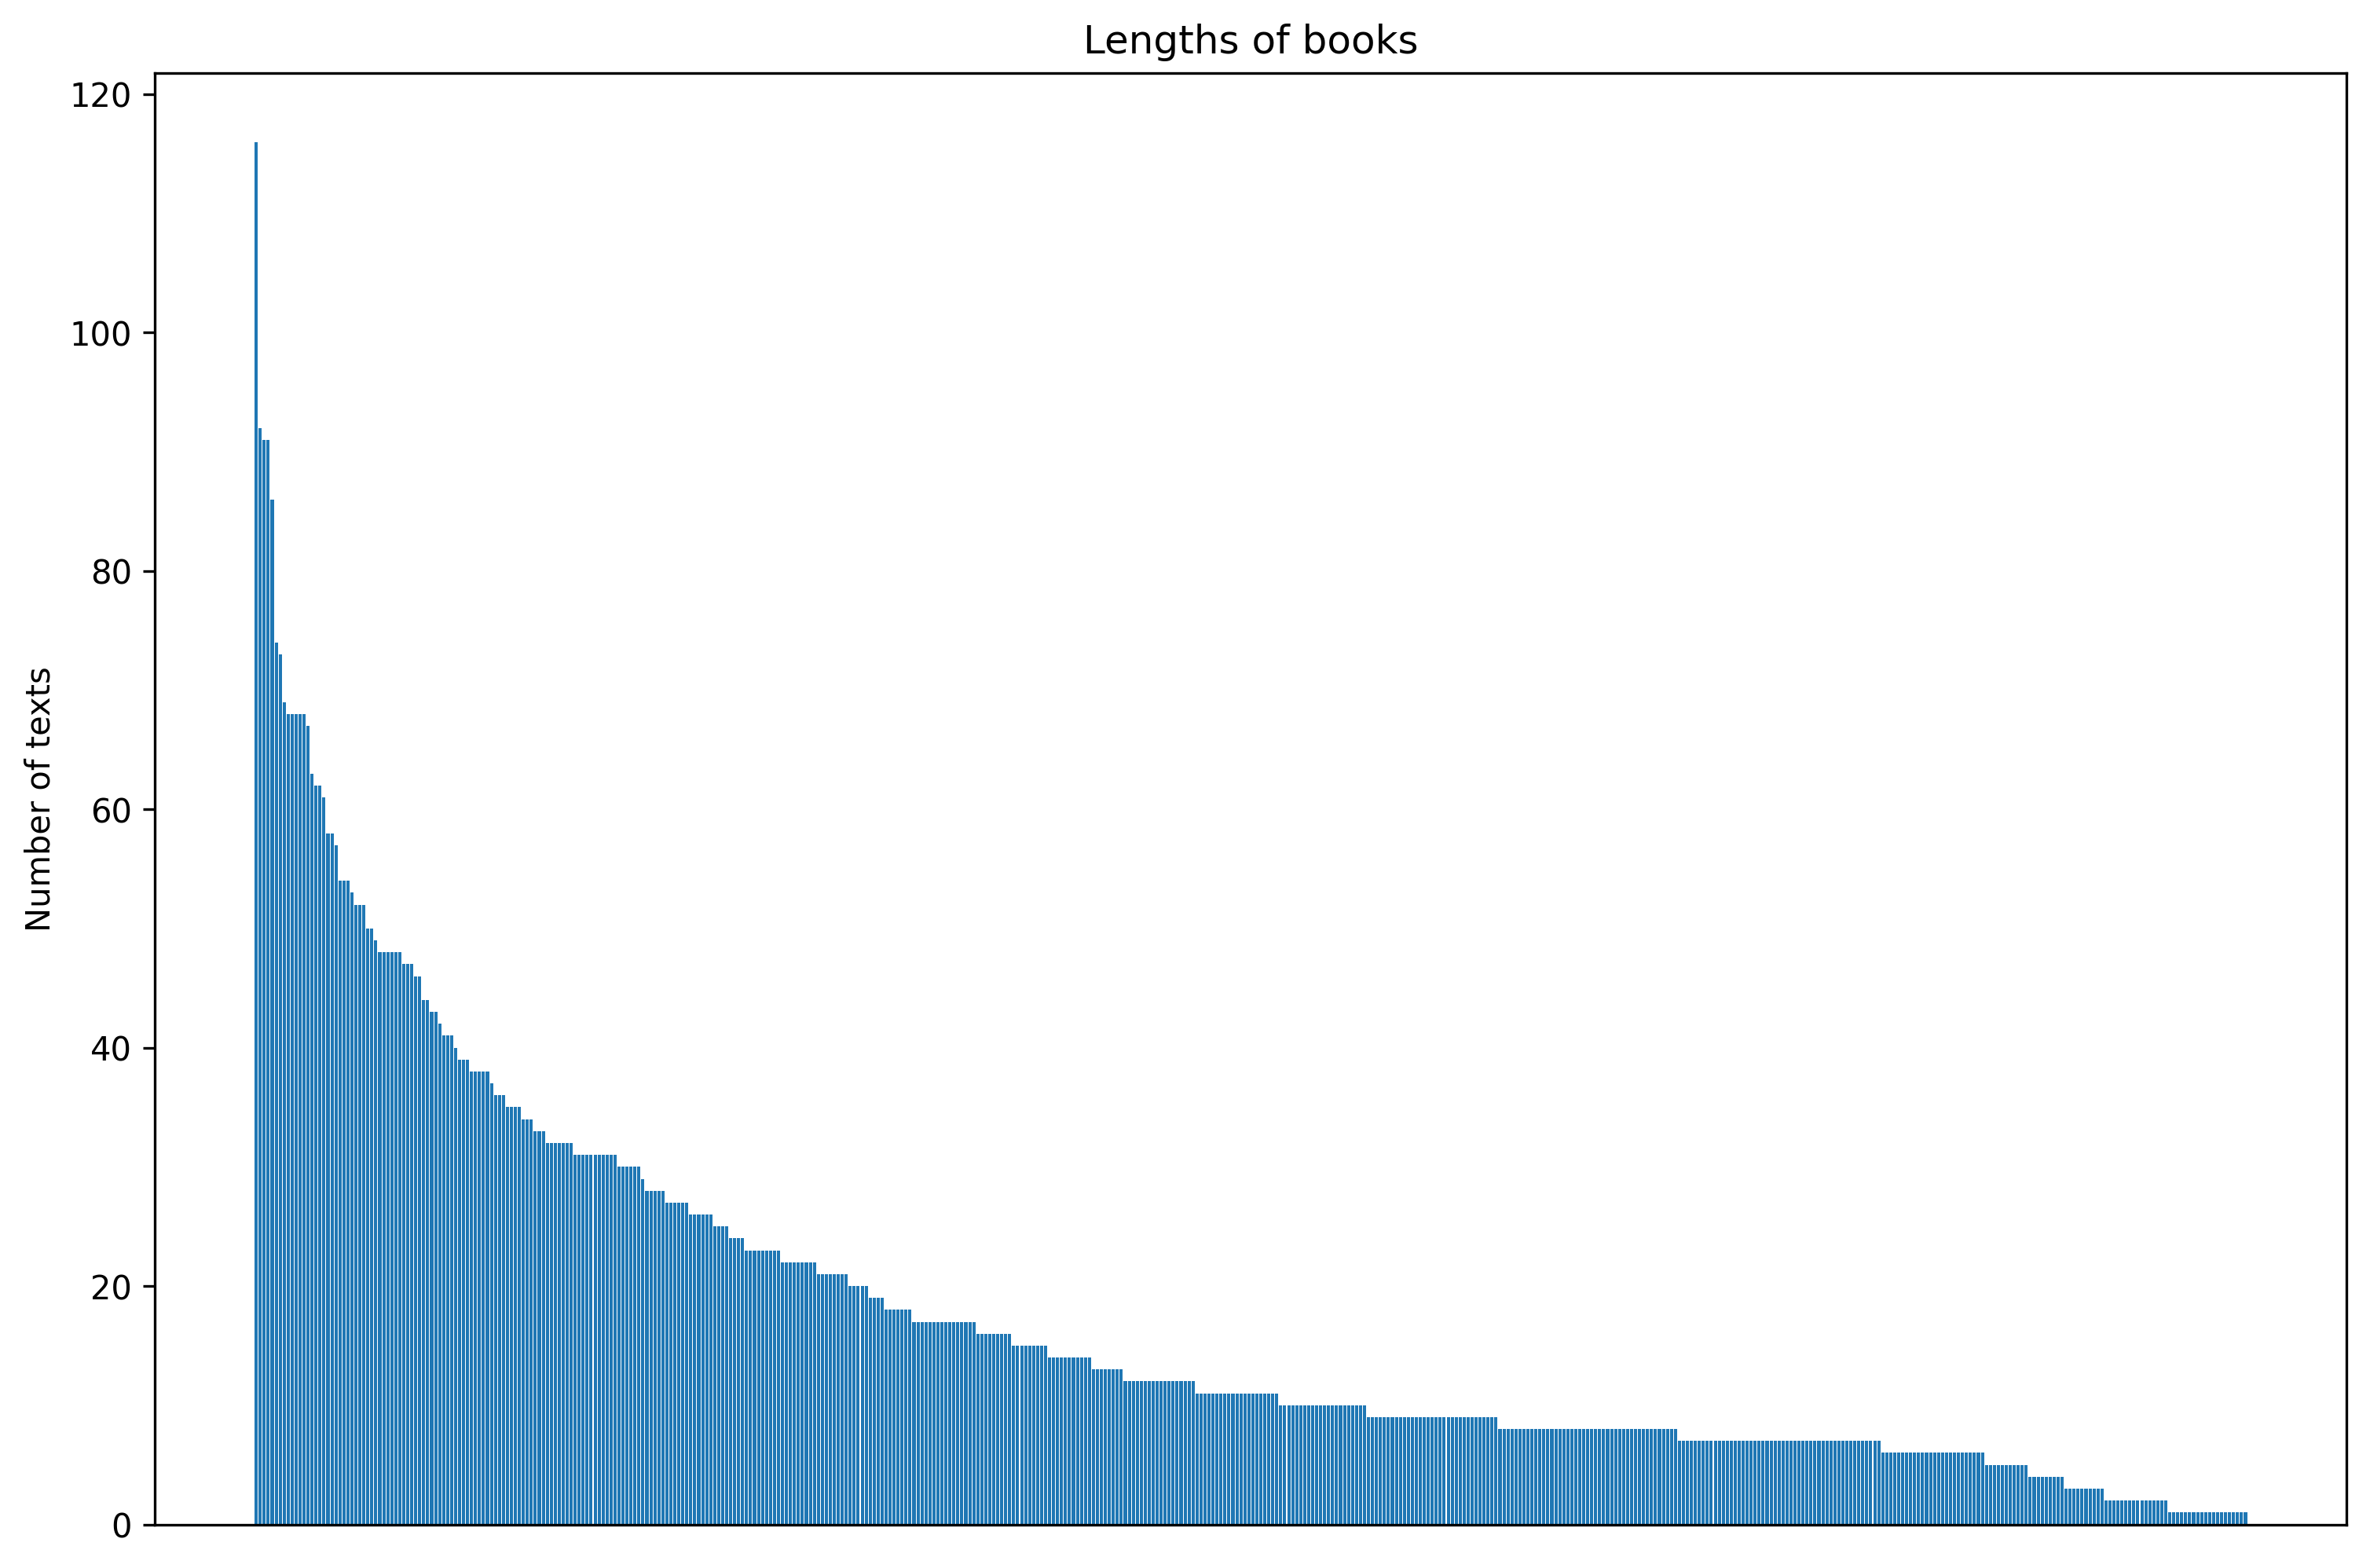

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
        figsize=(12,8),
        dpi=300
)
ax.bar(book_length["book_identifier"], book_length["items"])
ax.set_xticks([])
ax.set_ylabel("Number of texts")
ax.set_title("Lengths of books")

plt.show()

In [67]:
book_length = book_length.assign(
    bin=pd.cut(book_length["items"], bins=10, precision=0)
)

In [68]:
book_length_bins = book_length.groupby("bin").size().copy().reset_index(name="items").sort_values(by="bin", ascending=False)
book_length_bins

/var/folders/nl/vqk2y9kx4k53ld7qmn5h84z80000gn/T/ipykernel_49229/1462900131.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,bin,items
9,"(104.0, 116.0]",1
8,"(93.0, 104.0]",0
7,"(82.0, 93.0]",4
6,"(70.0, 82.0]",2
5,"(58.0, 70.0]",11
4,"(47.0, 58.0]",19
3,"(36.0, 47.0]",26
2,"(24.0, 36.0]",56
1,"(12.0, 24.0]",99
0,"(1.0, 12.0]",282


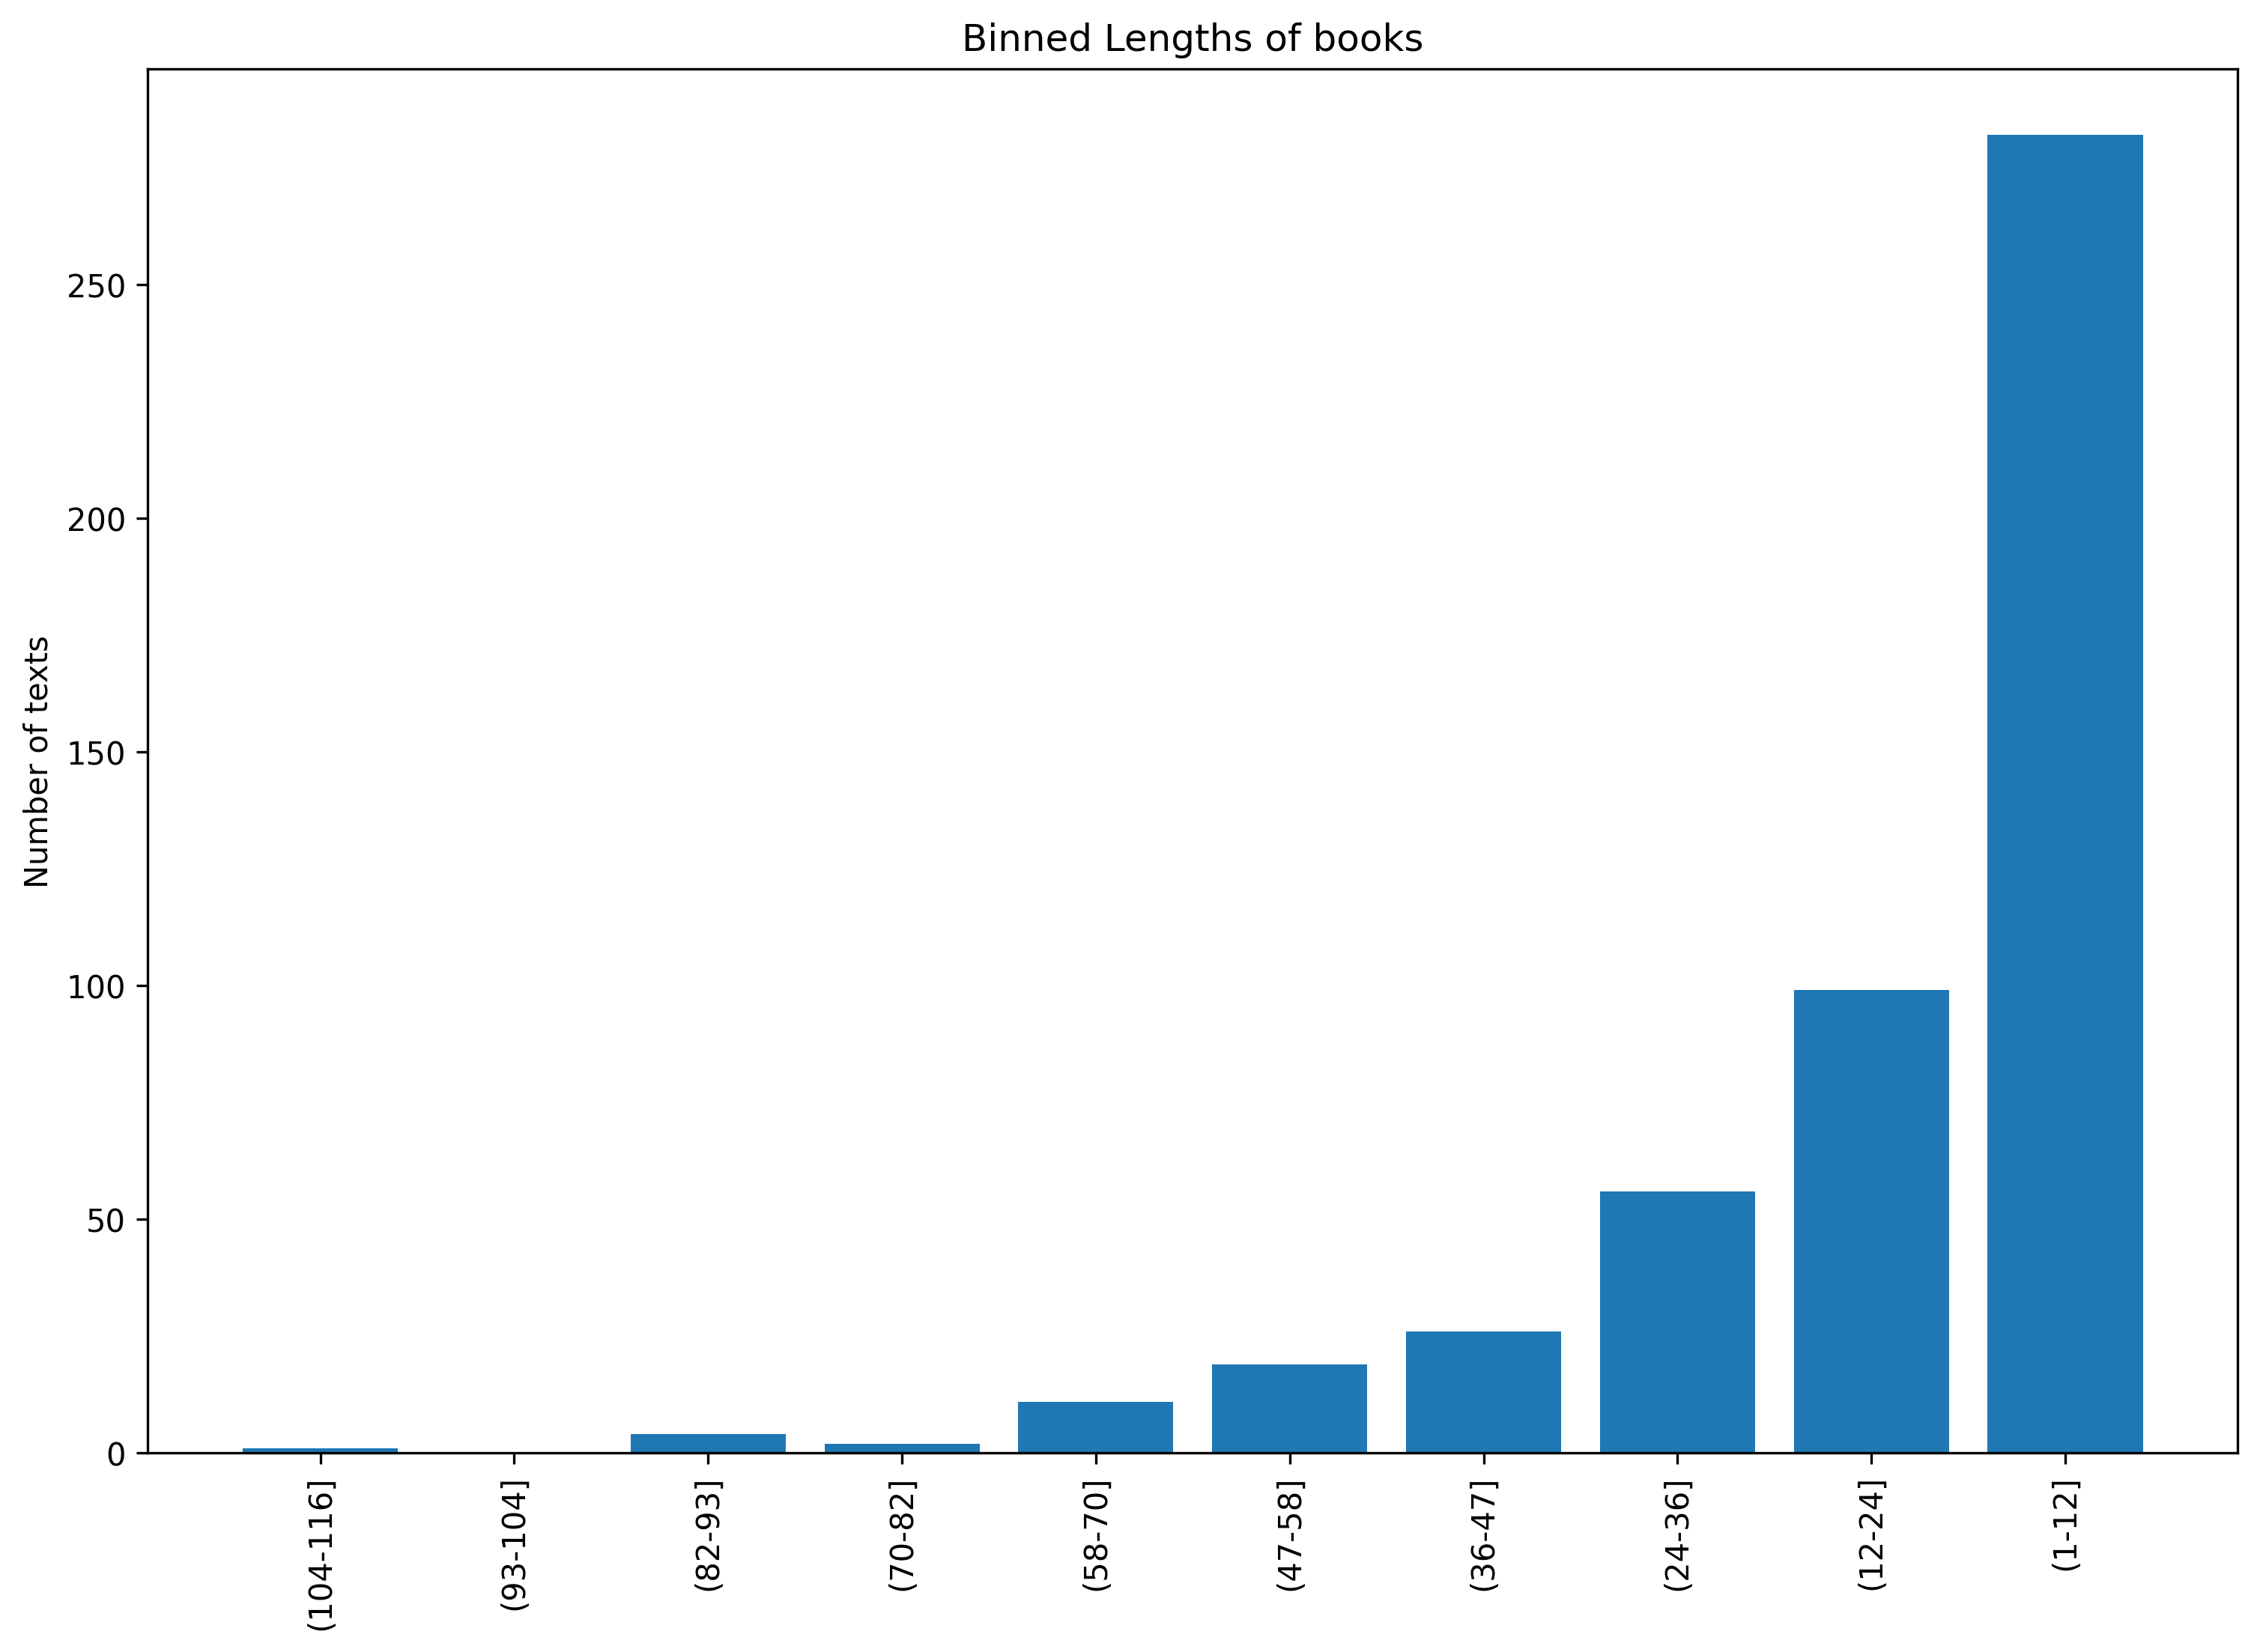

In [69]:
fig, ax = plt.subplots(
        figsize=(12,8),
        dpi=300
)
ax.bar(list(range(book_length_bins.shape[0])), book_length_bins["items"])
ax.set_xticks(list(range(book_length_bins.shape[0])))
ax.set_xticklabels([f"({int(i.left)}-{int(i.right)}]" for i in book_length_bins["bin"]], rotation=90)
ax.set_ylabel("Number of texts")
ax.set_title("Binned Lengths of books")

plt.show()

### Texts

In [91]:
text_freqs = dataset.groupby("text_id").size().copy().sort_values(ascending=False).reset_index(name="items")
text_freqs

,text_id,items
0,164.0,247
1,466.0,216
2,517.0,216
3,631.0,204
4,695.0,199
...,...,...
1562,136006.0,1
1563,136012.0,1
1564,136018.0,1
1565,136020.0,1


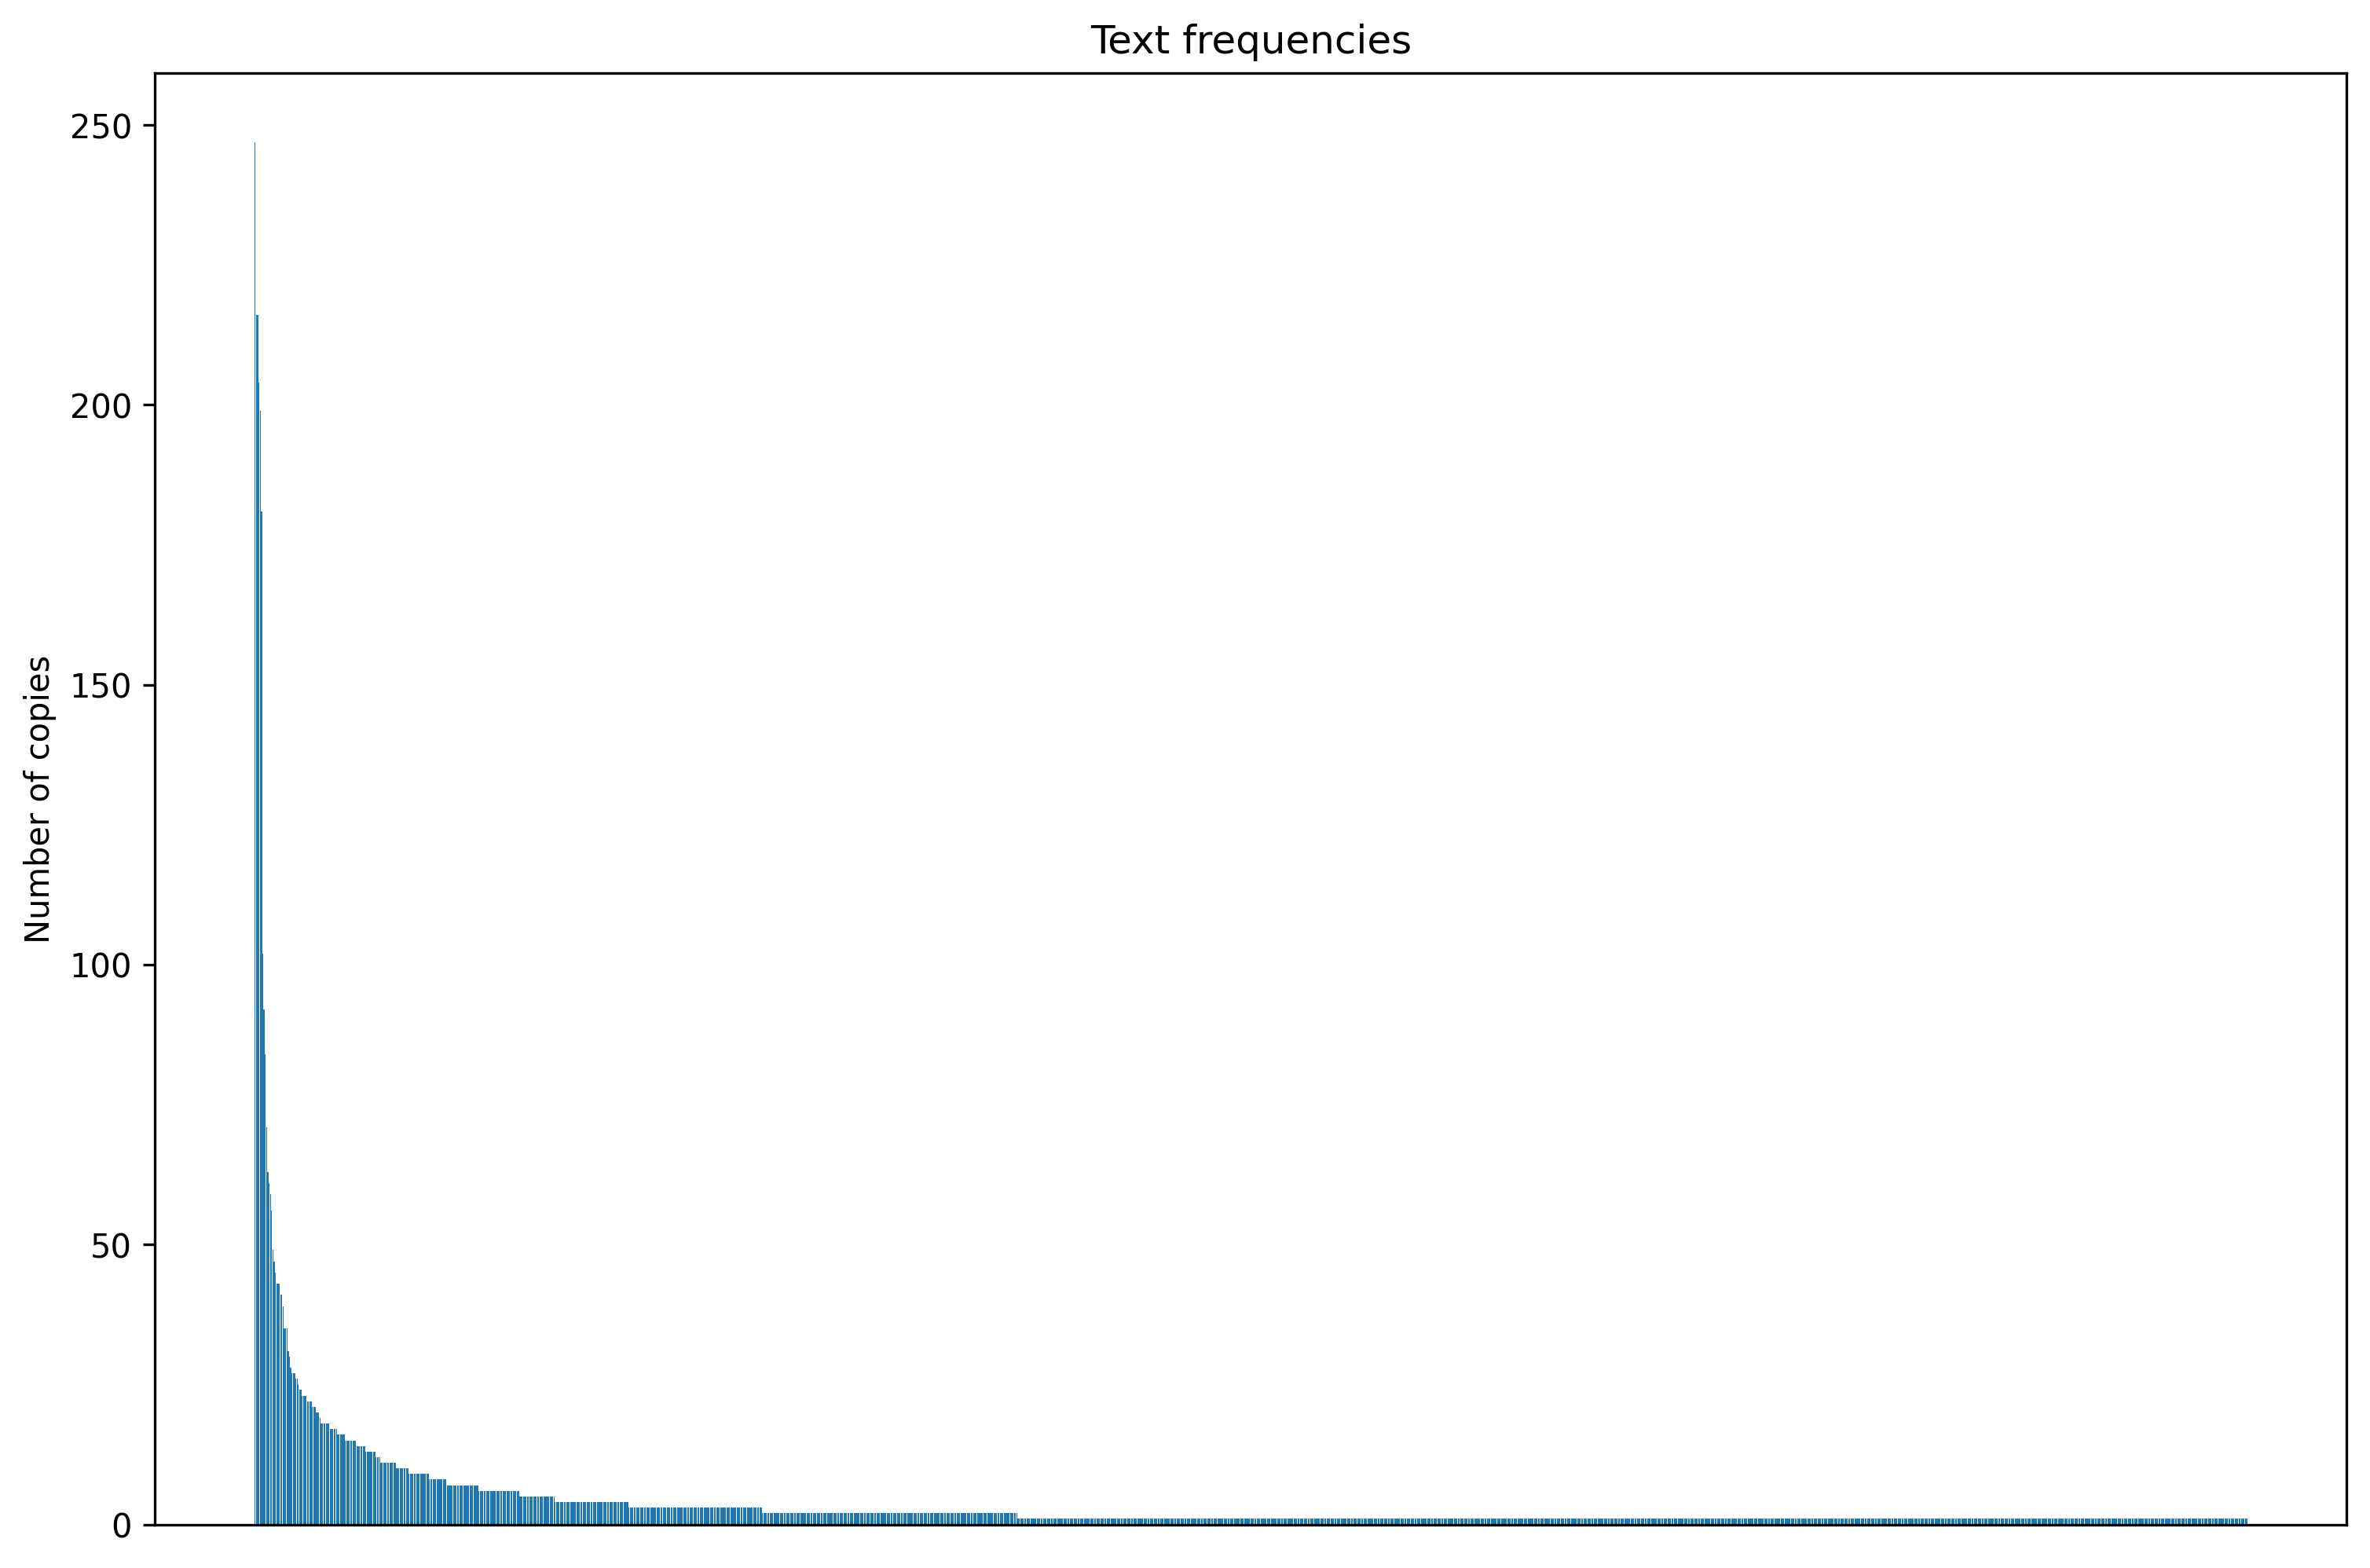

In [93]:
fig, ax = plt.subplots(
        figsize=(12,8),
        dpi=300
)
ax.bar(list(range(text_freqs.shape[0])), text_freqs["items"])
ax.set_xticks([])
ax.set_ylabel("Number of copies")
ax.set_title("Text frequencies")

plt.show()

## Co-Occurrences

In [98]:
def compute_adjacency(
        df: pd.DataFrame,
        left_context: Union[int, None] = None,
        right_context: Union[int, None] = None
):
    df = df[df["text_id"].notna()].copy()
    _, counts = np.unique(df["text_id"], return_counts=True)
    unique, labels = np.unique(df["text_id"], return_inverse=True)
    unique = unique.astype(int)
    text2idx = {int(t): i for i, t in enumerate(unique)}
    idx2text = {i: t for i, t in text2idx.items()}

    seqs = df.groupby("book_identifier")["text_id"].apply(list).to_dict()

    adjacency_matrix = np.zeros((len(unique), len(unique)), dtype=int)
    for seq in seqs.values():
        seq_indices = [text2idx[t] for t in seq]
        seq_len = len(seq_indices)

        for i, idx_i in enumerate(seq_indices):
            start = 0 if left_context is None else max(i - left_context, 0)
            end = seq_len if right_context is None else min(i + right_context + 1, seq_len)

            context_indices = seq_indices[start:i] + seq_indices[i + 1:end]

            # this will count all occurrences with itself, which may be interesting
            # context_indices = seq_indices[start:end]

            for idx_j in context_indices:
                adjacency_matrix[idx_i, idx_j] += 1

    adj_df = pd.DataFrame(adjacency_matrix, index=unique, columns=unique, dtype=int)

    return adj_df, text2idx, idx2text

In [102]:
cooc_df, text2idx, idx2text = compute_adjacency(
    df=dataset,
    left_context=3,
    right_context=3
)

In [103]:
cooc_df

,164,168,171,192,197,260,461,466,515,517,...,143407,143411,143412,143467,143504,143505,143506,143507,143513,143947
164,2,0,0,4,41,0,26,67,1,42,...,0,0,1,0,0,1,1,0,0,0
168,0,0,29,0,1,18,2,25,0,33,...,0,0,0,0,0,0,0,0,0,0
171,0,29,0,0,1,24,0,3,0,8,...,0,0,0,0,0,0,0,0,0,0
192,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,41,1,1,1,0,0,0,25,1,21,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143505,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
143506,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
143507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
def sorted_values(
    cooccurrences_df: pd.DataFrame,
    target_text_id: int
) -> List[Tuple[int, int]]:
    """
    Takes a df with adjacencies and a target_text_id. Returns sorted co-occurrences for sorted target_text_id.
    :param cooccurrences_df:
    :param target_text_id:
    :return:
    """
    cooccurrences = cooccurrences_df[target_text_id].copy().sort_values(ascending=False)

    return cooccurrences

In [95]:
sorted_values(
    cooccurrences_df=cooc_df,
    target_text_id=164
).sum()

np.int64(5230)

In [101]:
cooc_df.loc[164,164]

np.int64(2)

In [104]:
def compute_pmi(
        cooc_matrix: pd.DataFrame,
        positive: bool = True,
        power: Union[int, float] = 1.0
) -> np.ndarray:
    rows = cooc_matrix.index
    cols = cooc_matrix.columns
    total_coocs = np.sum(cooc_matrix.values)
    sum_over_rows = np.sum(cooc_matrix.values, axis=1, keepdims=True)
    sum_over_cols = np.sum(cooc_matrix.values, axis=0, keepdims=True)

    p_xy = cooc_matrix / total_coocs
    p_x = sum_over_rows / total_coocs
    p_y = sum_over_cols / total_coocs

    with np.errstate(divide='ignore', invalid='ignore'):
        pmi_matrix = np.log((p_xy ** power) / (p_x @ p_y))
        pmi_matrix[np.isinf(pmi_matrix)] = 0.0  # handle log(0) cases gracefully
        pmi_matrix = np.nan_to_num(pmi_matrix)

    if positive:
        pmi_matrix = np.maximum(pmi_matrix, 0)

    pmi_df = pd.DataFrame(data=pmi_matrix, index=rows, columns=cols)
    return pmi_df

In [105]:
low_freq_df = dataset.groupby("text_id").size().copy().sort_values(ascending=False).reset_index(name="items")
gt_texts = low_freq_df[low_freq_df["items"] >= 3]["text_id"].tolist()
print(len(gt_texts))
low_freq_df


399


,text_id,items
0,164.0,247
1,466.0,216
2,517.0,216
3,631.0,204
4,695.0,199
...,...,...
1562,136006.0,1
1563,136012.0,1
1564,136018.0,1
1565,136020.0,1


In [106]:
pmi_df = compute_pmi(cooc_matrix=cooc_df.loc[gt_texts, gt_texts], power=1)

In [109]:
pmi_df.values

array([[0.        , 0.34835061, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.34835061, 0.        , 1.37470697, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.37470697, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(399, 399))

In [107]:
sorted_values(
    cooccurrences_df=pmi_df,
    target_text_id=164
)

631       1.922659
192       1.779340
130406    1.738518
133351    1.718715
125147    1.575428
            ...   
138716    0.000000
127673    0.000000
127552    0.000000
140219    0.000000
136305    0.000000
Name: 164, Length: 399, dtype: float64

In [62]:
from umap import UMAP
import plotly.express as px

reducer = UMAP(
    n_components=2,
    n_neighbors=2,
    min_dist=0.01,
    metric='precomputed',
)

embeddings = reducer.fit_transform(pmi_df.max() - pmi_df)

fig = px.scatter(
    embeddings, x=0, y=1, hover_name=pmi_df.index
)
fig.show()

/Users/glebschmidt/projects/prayer_clusters/.venv/lib/python3.11/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable



[4 4 4 4 4 4 4 4 4 4 1 4 4 4 1 1 4 4 4 1 2 0 4 4 1 4 4 4 1 1 0 4 4 4 4 1 4
 2 4 1 2 3 4 3 4 4 1 2 1 1 4 1 0 0 4 4 2 4 0 2 0 3 0 2 2 2 0 1 2 2 4 0 1 3
 4 4 4 1 0 0 0 1 0 4 4 0 2 4 0 4 4 0 3 4 4 0 2 0 0 4 2 4 0 4 4 4 4 4 0 4 4
 4 4 4 3 4 4 4 4 3 4 0 4 4 4 0 4 4 3 2 4 4 1 4 4 0 4 4 4 0 4 0 4 4 4 4 2 4
 4 4 4 4 4 4 4 4 0 4 4 4 3 0 4 2 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 2 4 1 4 0
 1 1 4 2 4 4 4 4 4 3 4 4 4 4 2 4 4 1 4 4 4 3 1 3 1 4 0 4 4 4 4 0 0 4 4 0 4
 0 4 2 3 4 3 2 4 2 1 4 3 4 4 0 0 3 2 1 4 0 3 0 0 4 3 3 0 4 1 4 1 4 4 4 3 4
 4 4 4 4 4 0 4 1 2 1 0 2 4 4 2 4 4 4 0 1 4 4 4 4 0 1 3 4 3 0 4 4 3 4 2 4 4
 4 4 2 4 4 4 4 4 4 4 4 4 4 4 0 3 4 0 4 0 4 0 2 4 1 4 4 4 0 4 4 4 4 4 3 4 4
 4 1 4 4 4 4 3 1 4 1 4 0 1 4 4 4 4 4 2 0 3 4 1 4 4 0 4 0 4 4 1 4 4 1 4 1 4
 4 4 4 4 4 0 4 0 2 4 4 4 2 4 0 4 0 4 4 4 4 4 4 2 1 4 3 4 0]


/Users/glebschmidt/projects/prayer_clusters/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.

/Users/glebschmidt/projects/prayer_clusters/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Users/glebschmidt/projects/prayer_clusters/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Users/glebschmidt/projects/prayer_clusters/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul

